# Kaggle Credit Card Dataset
I'm using a dataset hosted by Kaggle <a href"https://www.kaggle.com/dalpozz/creditcardfraud">here</a>. The original data is from: Andrea Dal Pozzolo, Olivier Caelen, Reid A. Johnson and Gianluca Bontempi. Calibrating Probability with Undersampling for Unbalanced Classification. In Symposium on Computational Intelligence and Data Mining (CIDM), IEEE, 2015.

The dataset has 284,807 transactions, 492 of which are fradulent. This is 0.172% of the transactions. As noted on the webpage, due to privacy issues, most of the features have already been transformed with PCA. 'Time' and 'Amount have not been transformed. 'Time' is in seconds and it is relative to $t_0$, the first data point. 'Amount' is the amount of the transaction (currency not given). 'Class' is the response. Fraud is 1 and normal transactions are 0.

This seems like an appropriate dataset for the UnifyID challenge because their product is authentication. They have to identify normal behavior patterns for a person and prevent impersonators, or outliers. This is analogous to the fraudulent transactions. Impersonators are likely rare events, which is further analogous to credit card fraud.

In [1]:
%matplotlib inline

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from pandas.tools.plotting import scatter_matrix
from sklearn.model_selection import train_test_split

In [3]:
#load the dataset into pandas
data = pd.read_csv('creditcard.csv')
data.head()

,Time,V1,V2,V3,V4,V5,V6,V7,V8,V9,...,V21,V22,V23,V24,V25,V26,V27,V28,Amount,Class
0,0.0,-1.359807,-0.072781,2.536347,1.378155,-0.338321,0.462388,0.239599,0.098698,0.363787,...,-0.018307,0.277838,-0.110474,0.066928,0.128539,-0.189115,0.133558,-0.021053,149.62,0
1,0.0,1.191857,0.266151,0.166480,0.448154,0.060018,-0.082361,-0.078803,0.085102,-0.255425,...,-0.225775,-0.638672,0.101288,-0.339846,0.167170,0.125895,-0.008983,0.014724,2.69,0
2,1.0,-1.358354,-1.340163,1.773209,0.379780,-0.503198,1.800499,0.791461,0.247676,-1.514654,...,0.247998,0.771679,0.909412,-0.689281,-0.327642,-0.139097,-0.055353,-0.059752,378.66,0
3,1.0,-0.966272,-0.185226,1.792993,-0.863291,-0.010309,1.247203,0.237609,0.377436,-1.387024,...,-0.108300,0.005274,-0.190321,-1.175575,0.647376,-0.221929,0.062723,0.061458,123.50,0
4,2.0,-1.158233,0.877737,1.548718,0.403034,-0.407193,0.095921,0.592941,-0.270533,0.817739,...,-0.009431,0.798278,-0.137458,0.141267,-0.206010,0.502292,0.219422,0.215153,69.99,0


The outlier detection algorithm is going to be trained on normal transactions first, so I need to separate out the fradulent transactions.

In [4]:
fraud_transactions = data[data.Class==1]

In [5]:
#check that Class is 1 for all data points, i.e. mean = 1 and std = 0
fraud_transactions.Class.describe()

count    492.0
mean       1.0
std        0.0
min        1.0
25%        1.0
50%        1.0
75%        1.0
max        1.0
Name: Class, dtype: float64

In [6]:
normal_transactions = data[data.Class!=1]

In [7]:
#check that Class is 0 for all data points, i.e. mean = 0 and std = 0
normal_transactions.Class.describe()

count    284315.0
mean          0.0
std           0.0
min           0.0
25%           0.0
50%           0.0
75%           0.0
max           0.0
Name: Class, dtype: float64

There's not much to learn from the transformed variables, since they're an orthogonal basis, but the 'Time' and 'Amount variables still have meaning.

In [8]:
fraud_transactions['Amount'].describe()

count     492.000000
mean      122.211321
std       256.683288
min         0.000000
25%         1.000000
50%         9.250000
75%       105.890000
max      2125.870000
Name: Amount, dtype: float64

In [9]:
normal_transactions['Amount'].describe()

count    284315.000000
mean         88.291022
std         250.105092
min           0.000000
25%           5.650000
50%          22.000000
75%          77.050000
max       25691.160000
Name: Amount, dtype: float64

The fraudulent transactions are larger than the normal transactions on average, but at least 50% of the fraudulent transactions are <10. What does the distribution look like?

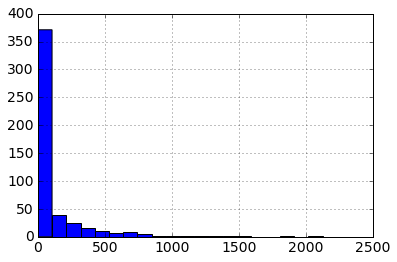

In [10]:
fraud_transactions['Amount'].hist(bins=20) #create a histogram of 'Amounts' for the fraudulent transations

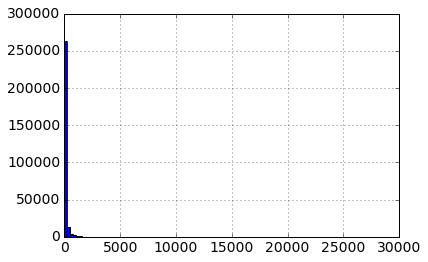

In [11]:
normal_transactions['Amount'].hist(bins=100) #create a histogram of 'Amounts' for the normal transations

The distributions seem similar, except that the fradulent transactions seem mostly smaller, as seen above. What about the frequency of the fraudulent transactions?

(-0.5, 1.5)

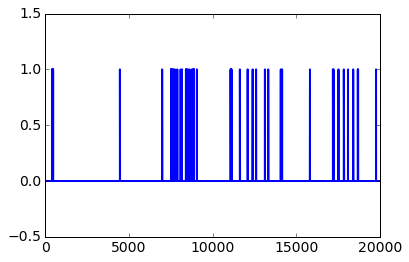

In [12]:
plt.plot(data.Time, data.Class) #plot the class vs time
plt.xlim((0,20000))
plt.ylim((-0.5,1.5))

It looks like the transactions come in waves. However, I feel this would only be meaningful if I could determine if it's the same credit card. For this reason, I will ignore the 'Time' feature.

Since the training data is only normal transactions, rotation estimation like k-fold cross validation won't work. I'll divide my data into 50/20/20 train/validation/test, plus save 10% for creating the update code. The validation, test, and update sets will have fraudulent transactions in the same proportion. This way, the fraudulent transactions will still be rare. I'll be using the ```train_test_split()``` utility from scikit learn to perform the splitting. It automatically splits the data while keeping the proportions the same, as well as shuffles the data after the split. I will retain the 'Time feature for completeness, but I won't necessarily use it.

In [13]:
# separate the normal transactions into X and y variables
X_normal = normal_transactions.copy().drop('Class', axis=1)
y_normal = normal_transactions.copy().Class

In [14]:
# double check that X_normal.shape = (284315, 30)
X_normal.shape

(284315, 30)

In [15]:
# double check that y_normal.shape = (284315, )
y_normal.shape

(284315,)

In [16]:
#make a first split
#142403 rows go to the training set and the rest go to the second set
X_train, X_norm_val_test, y_train, y_norm_val_test = train_test_split(X_normal, y_normal, train_size=142403, 
                                                                      random_state=42)

In [17]:
#double check that X_train and y_train have 142403 rows
X_train.shape

(142403, 30)

In [18]:
y_train.shape

(142403,)

In [19]:
# separate the normal transactions into X and y variables
X_fraud = fraud_transactions.copy().drop('Class', axis=1)
y_fraud = fraud_transactions.copy().Class

In [20]:
# double check that X_fraud.shape = (492, 30)
X_fraud.shape

(492, 30)

In [21]:
# double check that y_fraud.shape = (492, )
y_fraud.shape

(492,)

In [22]:
# add the fraudulent transactions to the norm_val_test sets
X_val_test = X_norm_val_test.append(X_fraud)
y_val_test = y_norm_val_test.append(y_fraud)

In [23]:
#check that X_val_test.shape = (142404, 30)
X_val_test.shape

(142404, 30)

In [24]:
# check that y_val_test.shape = (142404, )
y_val_test.shape

(142404,)

In [25]:
# make a second split for the validation set (now a 40/60 split)
X_val, X_test_update, y_val, y_test_update = train_test_split(X_val_test, y_val_test, train_size=0.4, random_state=94)

In [26]:
# check that the validation sets have 56961 rows and the test_update sets have 85443 rows
X_val.shape

(56961, 30)

In [27]:
X_test_update.shape

(85443, 30)

In [28]:
y_val.shape

(56961,)

In [29]:
y_test_update.shape

(85443,)

In [30]:
# check that the percent of fraudulent transactions is similar between the validation and test_update sets
#since the classes are 0 and 1, the sum is the same as counting instances of class 1
val_percent = y_val.sum() / y_val.shape[0] * 100
val_percent

0.3440950826003757

In [31]:
test_update_percent = y_test_update.sum() / y_test_update.shape[0] * 100
test_update_percent

0.34642978359842236

These percentages are about double the percentage of the original dataset. This is correct, since we removed half of the normal transactions into the training dataset without removing any fradulent transactions.

In [32]:
# make a third split for the test and update sets (now a ~66/34 split)
X_test, X_update, y_test, y_update = train_test_split(X_test_update, y_test_update, train_size=56961, random_state=89)

In [33]:
# check that the test sets have 56961 rows and the update sets have 28482 rows
X_test.shape

(56961, 30)

In [34]:
X_update.shape

(28482, 30)

In [35]:
y_test.shape

(56961,)

In [36]:
y_update.shape

(28482,)

In [37]:
# check that the percent of fraudulent transactions is similar between the validation and test_update sets
test_percent = y_test.sum() / y_test.shape[0] *100
test_percent

0.3370727339758782

In [38]:
update_percent = y_update.sum() / y_update.shape[0] *100
update_percent

0.36514289726845023

In [39]:
#write the sets to csv files for easy retrieval later
#y_train is likely not necessary, but it's good to have, just in case
#X_train.to_csv('X_train.csv', index=False)
#y_train.to_csv('y_train.csv', index=False)
#X_val.to_csv('X_val.csv', index=False)
#y_val.to_csv('y_val.csv', index=False)
#X_test.to_csv('X_test.csv', index=False)
#y_test.to_csv('y_test.csv', index=False)
#X_update.to_csv('X_update.csv', index=False)
#y_update.to_csv('y_update.csv', index=False)